<a href="https://colab.research.google.com/github/DrMarc/slab/blob/master/slab_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Slab tutorial

Welcome to a short demonstration of **slab** ('es-lab', or sound laboratory), a Python package that makes working with sounds and running psychoacoustic experiments simple, efficient, and fun!

Let's install slab with pip. We have to do two things to make this work in a notebook: 1) uninstall the SoundCard module (used to play sounds when you run slab locally on your computer), and 2) set the `in_notebook` variable to True (see below).

> Note: You have to confirm the uninstall of SoundCard by clicking just to the right of `Proceed (Y/n)?` when it appears below and then pressing Enter or the 'y' key.

In [3]:
!pip install slab
!pip uninstall SoundCard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.0/739.0 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 4.0 MB/s eta 0:00:00
Found existing installation: SoundCard 0.4.2
Uninstalling SoundCard-0.4.2:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/SoundCard-0.4.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/soundcard/*
Proceed (Y/n)? 
  Successfully uninstalled SoundCard-0.4.2


You should now have a working installation of slab. Let's import it and print the version string to check that everything went well. We also set the _in_notebook variable to True so that sounds are played correctly (via IPython) and an interactive play button is shown. This is not necessary when you run slab locally.

In [4]:
import slab
print(slab.__version__)
slab.sound._in_notebook=True

1.1.5


As a second check, we'll generate a sound consisting of many sine waves. Plot it's spectrum and waveform, and play it (calling the play method produces an IPython audio player element in notebooks):

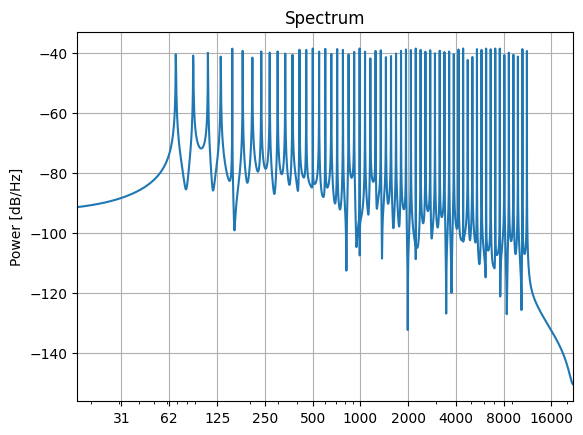

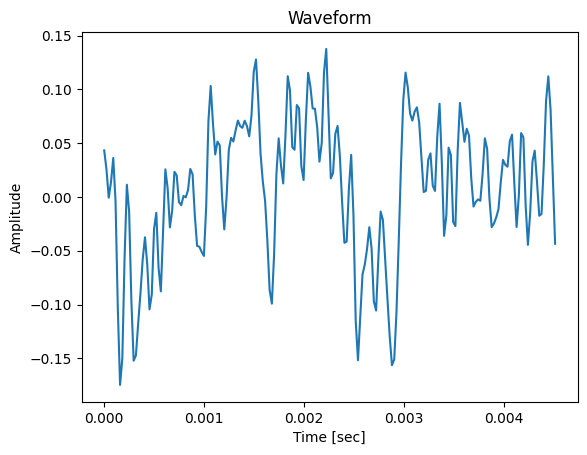

In [5]:
slab.set_default_samplerate(44100)
sig = slab.Sound.multitone_masker(duration=3., low_cutoff=50, high_cutoff=12000, bandwidth=1/9)
sig.spectrum()
sig.waveform(end=200)
sig.play()

The function `slab.Sound.multitone_masker` above is an example of the many functions to generate and manipulate experimental stimuli.

## Implementing an actual experiment

### Building the stimulus
Let's look at an actual example from the psychoacoustic literature. Viemeister (1979, **JASA** 66(5), 1364–80) measured modulation transfer functions, i.e. the detectability of amplitude modulation dependent on the modulation frequency, by presenting a 1-sec long pink noise with an average level of 77dB. The amplitude of this noise was then modulated sinusoidally with frequencies between 2 anf 4000 Hz.

We use the `slab.Sound.pinknoise` method to generate a pink noise, set the level to 77 dB and add 5 ms onset and offset ramps to avoid click artifacts, and then play the sound:

In [ ]:
base_stimulus = slab.Sound.pinknoise(duration=1.)
base_stimulus.level = 77
base_stimulus = base_stimulus.ramp(duration=0.005)
base_stimulus.play()

Pink noise decreases in amplitude with increasing frequency such that the sound energy per octave is constant. You can see this decrease in the spectrum:

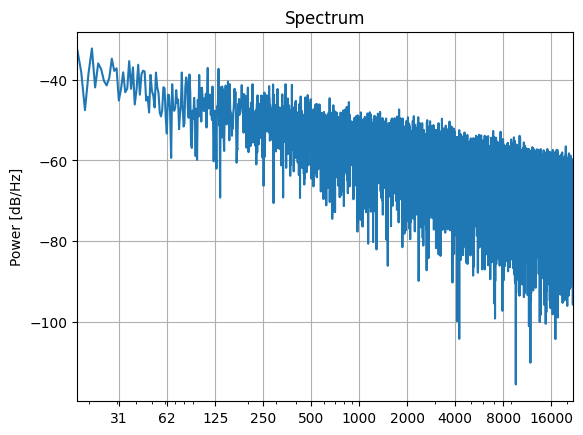

In [ ]:
base_stimulus.spectrum()

The ramp should be visible in the waveform. Lets plot the first 5 ms:

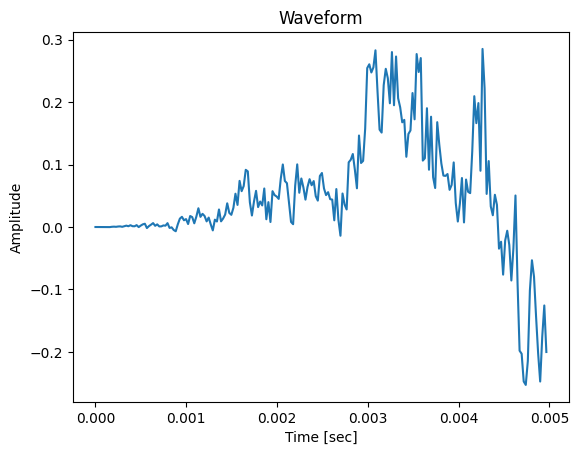

In [ ]:
base_stimulus.waveform(end=0.005)

The waveform should start with an amplitude of zero and then slowly ramp up. You can check the offset of the waveform (using the `start` and `end` parameters).

We can also check that the sound has the correct duration and expected number of samples. One way to get information about a sound object by just printing it, which will list most of its properties:

In [ ]:
print(base_stimulus)

<class 'slab.sound.Sound'> duration 1.0, samples 44100, channels 1,samplerate 44100


We can now add the amplitude modulation using the `am` method, for instance at 10 Hz, which yields a sort of helicopter noise:

In [ ]:
mod_10hz = base_stimulus.am(frequency=10, depth=0.5)
mod_10hz.play()

In the experiment, we would vary the modulation depth to find the depth that can just be noticed. You can also adjust the `depth` parameter to lower and lower values and listen each time to get an idea of where your own threshold is. To automatically adjust the modulation depth depending on the previous responses from a listener, you can use an adaptive staricase. Slab's `Staircase` class geneates staircase objects that return the correct stimulus parameter (for instance modulation depth) when used in a loop. Here is an example of a starcase object (`stairs`) that starts at a stimulus value of 10 and adjusts that value up or down (initially in steps of 4 to quickly get in the neighbourhood of the threshold):

In [ ]:
stairs = slab.Staircase(start_val=10, n_reversals=18, step_sizes=[4,1])
stairs

{'label': '', 'start_val': 10, 'n_up': 1, 'n_down': 2, 'step_type': 'lin', 'step_sizes': [4, 1], '_variable_step': True, 'step_up_factor': 1, 'step_size_current': 4, 'n_reversals': 18, 'finished': False, 'n_pretrials': 0, 'this_trial_n': 0, 'data': [], 'intensities': [], 'reversal_points': [], 'reversal_intensities': [], 'current_direction': 'down', 'correct_counter': 0, '_next_intensity': 10, 'min_val': -inf, 'max_val': inf, 'pf_intensities': None, 'pf_percent_correct': None, 'pf_responses_per_intensity': None}

The last line above prints the internal state of the stairs object. All values can be accessed, for instance `stairs.this_trial_n`, or `stairs._next_intensity`. `stairs.intensities` keeps a record of all stimulus values that were presented and `stairs.data` saves all responses from the listener. `stairs.write(filename)` saves its contents to a results file, which can be read later to restore the object.

We can iterate of this object in a for loop to get a new stimulus value each time, depending on the listeners previous response, here simulated with the `simulate_response` method of the stairs object. Addint the response to the staircase calculates the next stimulus value and advances the staircase. `add_respinse` **must** be called on each iteration:

In [ ]:
for stimulus_value in stairs:
    response = stairs.simulate_response(threshold=3) # simulate subject's response
    stairs.add_response(response) # initiates calculation of next stimulus value

 Finally, we plot the responses as function of the trial number and return the threshold:

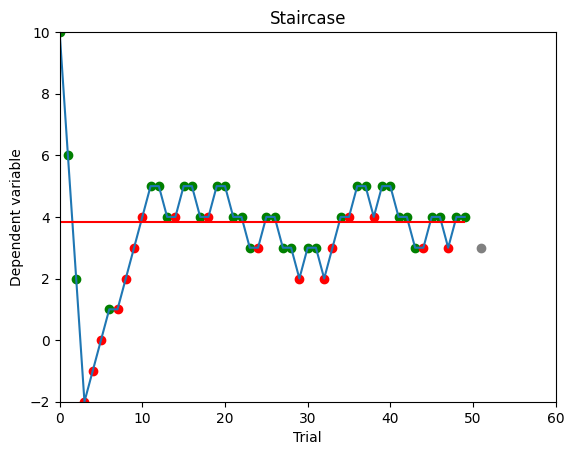

3.823529411764706

In [ ]:
stairs.plot()
stairs.threshold()

When running an actual experiment, you can call the plot function in the loop, after adding the response. This will update the plot each trial and provide a good feedback of how the listener performance to the experimenter.



### Measuring the modulation detection threshold
Asking the listener whether the sound was modulated or not can lead to bias in the responses. It's better to use an 'alternative forced choice' procedure, in which the listener has to indicate which one of several sound contained the modulation, and thus has to prove that he or she actually heard the modulation.

You can play several sounds in a random sequence, get a button press response, and compare it with the true position of the modulated sound. Because forces choice procedures are commonly used, the `Staircase` class has a convenience method for presenting complete trials and recording responses: `present_afc_trial`. We just supply the modulated and unmodulated sounds, and the response is automatically recorded into the `Staircase` object. Please have a look at the (very short) code of `present_afc_trial` to see how this is done.

We are now ready to measure the just noticeable modulation depth at one modulation frequency:

In [ ]:
slab.psychoacoustics.input_method = 'prompt'  # use Python 'prompt' to get responses in a Colab notebook
stairs = slab.Staircase(start_val=0.8, n_reversals=2, step_type='db',
            step_sizes=10, min_val=0, max_val=1, n_up=1, n_down=1)
for depth in stairs:
    stimulus = base_stimulus.am(frequency=10, depth=depth)
    stairs.present_afc_trial(stimulus, base_stimulus)
print(stairs.threshold(n=2))

The staircase was very short. A real experiment would require more trials (higher `n_reversals`) and smaller step sizes.
The only thing left to do is measuring threshold at several modulation frequencies. See the full example on [slab.readthedocs](https://slab.readthedocs.io/en/latest/examples.html#temporal-modulation-transfer-function).

### Going further
*   Explore the stimulus generation functions in the `Sound` class with the inbuilt Python docstrings or the [reference on slab.readthedocs](https://slab.readthedocs.io/en/latest/reference.html) to make other kinds of stimuli.
*   Send github pull requests for stimuli that are not implemented yet.
*   Explore the `stairs` object to see how the data and responses are stored and use the `.write` and `.read` methods to save your trial data for later analysis.
*   Use the `simulate_response` method to simulate your experiment and optimize the accuracy and duration of different options before starting with participants. See [simulating-responses](https://slab.readthedocs.io/en/latest/psychoacoustics.html#simulating-responses).

### Trial sequences
Explore the `Trialsequence` class to present non-adaptive stimulus sequences. Just like staircases, `Trialsequence` objects return a new stimulus value or condition index on each iteration and come with powerful methods for controlled randomization, stimulus presentation, and sequence types. Here are three examples:

In [ ]:
# sequence of 5 conditions, repeated twice, without direct repetitions:
seq = slab.Trialsequence(conditions=5, n_reps=2)

# infinite sequence of color names:
seq = slab.Trialsequence(conditions=['red', 'green', 'blue'], kind='infinite')

# stimulus sequence for an oddball design:
seq = slab.Trialsequence(conditions=1, deviant_freq=0.12, n_reps=60)

You can use `seq.present_afc_trial` or `seq.present_tone_trial` for easy trial presentations if you need to record responses.

Often it is necessary to control the transitions between the individual conditions in a randomized trial sequences. For instance, you may want to ensure nearly equal transitions, or avoid certain combinations of subsequent conditions entirely. The `.transitions` method counts, for each condition, how often every other condition follows it:

In [ ]:
seq = slab.Trialsequence(conditions=5, n_reps=20)
seq.transitions()

array([[0., 5., 8., 3., 4.],
       [3., 0., 6., 5., 5.],
       [2., 4., 0., 8., 6.],
       [6., 4., 5., 0., 5.],
       [8., 7., 1., 4., 0.]])

In the sequences above, the numbers 0 to 4 are repeated 20 times each without direct repetition (a number never follows itself, thus the diagonal zeros). Each of the 5 conditions is repeated 20 times, each time followed randomly by one of the 4 others. The 5x5 transition matrix shows how many times each condition follows another. If all transitions occured equally often, there would be a 5 in each cell, but you might find 2s or 8s as well. You might want to get almost equal transition probabilities to avoid stimulus history confounds. An easy way to achieve that is by brute force - generating new sequences until one satisfies the constraint of some maximum deviation from equality.

In [ ]:
import numpy
trans = 10
while numpy.any(trans>6):
    seq = slab.Trialsequence(conditions=5, n_reps=20)
    trans = seq.transitions()
print(trans)

[[0. 5. 5. 6. 4.]
 [4. 0. 5. 5. 6.]
 [6. 5. 0. 6. 3.]
 [6. 4. 4. 0. 6.]
 [4. 6. 6. 3. 0.]]


The pseudorandom sequence above is much closer to equal transition probabilities.

### Roving
In psychoacoustic experiments, the stimulus parameters that aer not under control sometimes need to be roved, i.e. randomy varied from trial to trial, so as to not be correlated with the experimental variables. For instance, if you present environmental stimuli, they might be difficult to present at exactly equal loudness. You could draw a random intensity in each trial to set the `.level` property of the stimulus, but true randomness is risky. You might rather use an infinite trialsequence to get a random level from a list of possibilities without direct repetition and guaranteed equal distribution of levels, while iterating over the trialsequence controlling the actual experimental variable:

In [ ]:
level_seq = slab.Trialsequence(conditions=[70, 72, 74, 76, 78, 80], kind='infinite')
trial_seq = slab.Trialsequence(conditions=['timbre1', 'timbre2', 'timbre3'], n_reps=5)
for trial in trial_seq:
  pseudorandom_level = next(level_seq)
  print(f'playing {trial} at {pseudorandom_level} dB')

playing timbre3 at 78 dB
playing timbre1 at 76 dB
playing timbre2 at 72 dB
playing timbre3 at 70 dB
playing timbre2 at 74 dB
playing timbre1 at 80 dB
playing timbre3 at 76 dB
playing timbre2 at 80 dB
playing timbre1 at 70 dB
playing timbre2 at 78 dB
playing timbre3 at 72 dB
playing timbre1 at 74 dB
playing timbre2 at 72 dB
playing timbre3 at 76 dB
playing timbre1 at 80 dB


Another option is the `Precomputed` class, which bundles several sounds into one `slab.Sound` object. The `.play` method of this object plays a random sound from the bundle, without direct repetition and keeps track of which sounds were played in the `.sequence`. See the example of [Precomputed on slab.readthedocs](https://slab.readthedocs.io/en/latest/reference.html).

### Results files

We still miss one vital element of a real experiment in the modulation transfer example above: a systematic way to save the results. You can do this yourself with a few Python commands, but because it is such a common requirement, slab provides a `Resultsfile` class for convenience. It automates the tasks of keeping results from all participants in a folder with consisten naming, adding time stamps to recorded data, saving the states of all slab objects used in experimental control (like staircases and trialsequences), and avoiding data loss when the experiment is interupted or the computer crashes.

Here is a simple example from the documentation:

In [ ]:
slab.ResultsFile.results_folder = 'MyResults'  # set the results folder
subject_ID = 'MS01'  # each participant should have an anonymising identifier
file = slab.ResultsFile(subject='MS')  # open the file (generating all needed folders)
print(file.path)
file.write(subject_ID, tag='ID')  # write something to the file (opened and closed for each write)

Results/MS/MS_2023-07-17-19-57-50.txt


In [ ]:
!cat Results/MS/MS_2023-07-17-19-57-50.txt

{"ID": "MS01"}


The information can be read back from the file, either while the experiment is running and you need to access a previously saved result (`.read()`), or for later data analysis (`ResultsFile.read_file()`):

In [ ]:
id = slab.ResultsFile.read_file(file.path, tag='ID')
print(id)

MS01


You can also easily write a whole `slab.Staircase`or `slab.Trialsequence` object to the file (`file.write(stairs)`).

### Going further
*   Try to add participant management and data recording to the modulation experiment above.
*   slab also provides a simple mechanism for managing config files (text files with parameter values for different versions of an experiment). See [configuration-files on slab.readthedocs](https://slab.readthedocs.io/en/latest/psychoacoustics.html#configuration-files).

## Binaural stimuli

We work a lot with spatial sounds and slab thus has function to work with binaural sounds (and head-related transfer functions, see below). The `slab.Binaural` class inherits all methods from the `slab.Sound` class and adds advanced methods to manipulate interaural parameters.

In [ ]:
noise = slab.Binaural.pinknoise(kind='diotic')  # new option to generate diotic or dichotic noise
noise.left.level = 75  # easy access to the left and right channels
noise.right.level = 85
noise.play()
print(noise)

<class 'slab.binaural.Binaural'> duration 1.0, samples 44100, channels 2,samplerate 44100


See [reference for the Binaural class on slab.readthedocs](https://slab.readthedocs.io/en/latest/reference.html#binaural-sounds) for the complete list of methods.

The methods `.itd` and `.ild` report and set the interaural time and intensity differences of a sound:

In [ ]:
print(noise.ild())
print(noise.itd())
noise = noise.ild(2)
noise = noise.itd(0.001)
print(noise.ild())
print(noise.itd()/noise.samplerate)

10.0
0
2.0020370776422993
0.000997732426303855


0.000997732426303855

To generate moving sounds, you can dynamically change these interaural differences with the `.itd_ramp` and `.ild_ramp` methods. Below, we also compute the correct ITD value for a given azimuth and `head_radius` (using the default 8.75cm). For frequencies >= 2 kHz the Woodworth (1962) formula is used. For frequencies <= 500 Hz the low-frequency approximation mentioned in Aronson and Hartmann (2014) is used. For frequencies in between, we interpolate linearly between the two.

The ILD is also frequency-dependent and the `.azimuth_to_ild` method uses an interaural level spectrum, computed from a measured head-related transfer function (defaults to the inbuilt KEMAR HRTF, see below). This computation can take a minute or two.

In [ ]:
noise = slab.Binaural.pinknoise(samplerate=44100)
ils = slab.Binaural.make_interaural_level_spectrum()  # extract ILD per freq band from HRTF
from_ild = slab.Binaural.azimuth_to_ild(-90, ils=ils)  # compute starting ILD and ITD
from_itd = slab.Binaural.azimuth_to_itd(-90)
to_ild = slab.Binaural.azimuth_to_ild(90, ils=ils)  # compute final ITD and ILD
to_itd = slab.Binaural.azimuth_to_itd(90)
noise_moving = noise.ild_ramp(from_ild, to_ild)  # apply the ramps
noise_moving = noise_moving.itd_ramp(from_itd, to_itd)

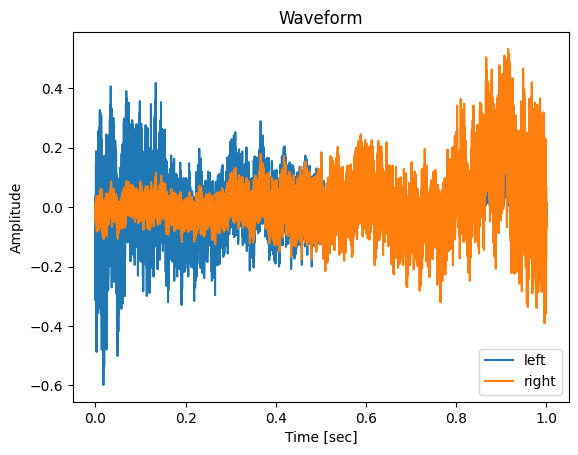

In [ ]:
noise_moving.waveform()
noise_moving.play()

This sound moves along the interaural axis. To `.externalise` the sound, we can convolve it with a smoothed HRTF to evoke the impression of an external sound source without adding directional information. See Kulkarni & Colburn (1998) for why that works.

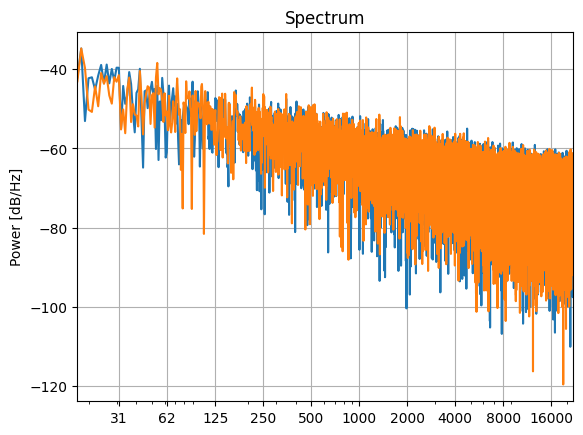

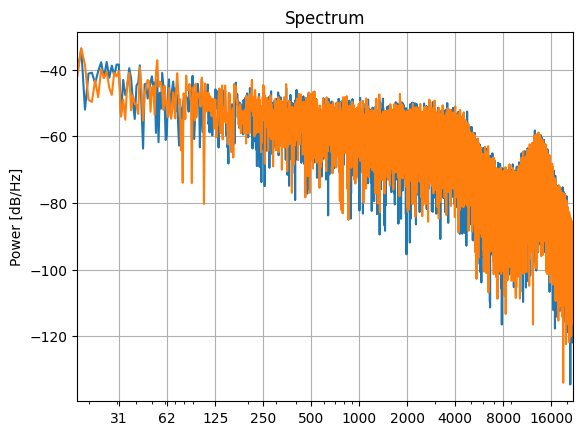

In [ ]:
noise_moving_ext = noise_moving.externalize()  # apply a smoothed pinna filter
noise_moving_ext.play()  # best heard through headphones
noise_moving.spectrum()  # compare spectra
noise_moving_ext.spectrum()

### Going further
*   Try to set up a time-intensity-trading experiment, where the ITD and ILD point in different directions. How is such an impossible combination interpreted by your hearing system?
*   See ["manipulating itd and ild"](https://slab.readthedocs.io/en/latest/sounds.html#manipulating-itd-and-ild) and the [reference for the Binaural class](https://slab.readthedocs.io/en/latest/reference.html#binaural-sounds) on slab.readthedocs.

## HRTF

The perception of sound directions along the vertical axis and in the back of the head depends on the directional filtering of incoming sound by the pinna and torso. These filters are called head-related transfer functions (HRTF).

Slab provides an `HRTF` class to read, write, cumpute, display, and manipulate HRTFs. One special HRTF is included with slab: the one from the binaural recording manequin KEMAR, measured by Gardner and Martin at MIT in 1994. Other can be read from databases that use the industry-standard SOFA file format for spatial audio. `HRTF` can read and write .sofa files.


<class 'slab.hrtf.HRTF'>, datatype FIR, sources 710, elevations 14, samplerate 44100.0, samples 512


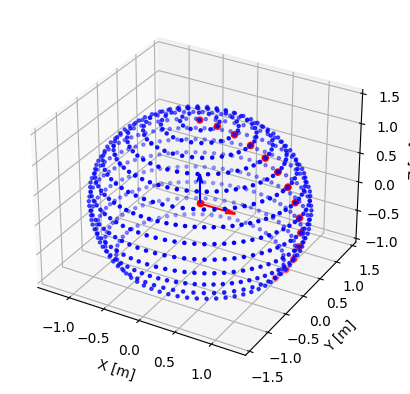

In [ ]:
hrtf = slab.HRTF.kemar()  # read in the KEMAR HRTF
print(hrtf)  # print it's properties
sidx = hrtf.cone_sources()  # select sources on the median cone of confusion
hrtf.plot_sources(sidx)  # plot all source positions in 3D, highlighting the selected ones

We can see that Gardner and Martin recorded signals from 710 loudspeakers around KEMAR, at 14 elevations (these are the vertically-stacked rings). The centre arrows show the listener position with up (blue) and forward (red) arrows.

If you run this code locally on your computer, you can interactively rotate the view to get a better impression.

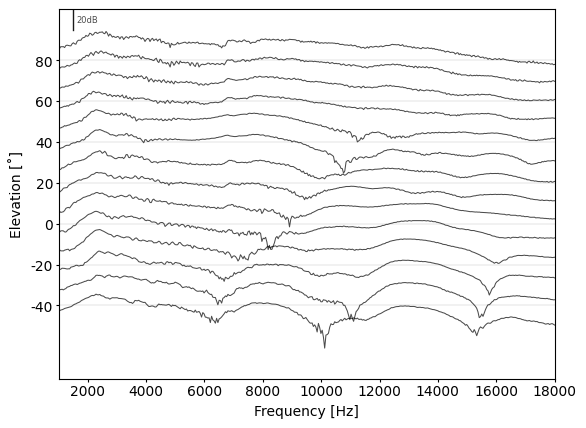

In [ ]:
hrtf.plot_tf(sidx)  # "waterfall" plot of the filter spectra for different elevations

As you can see the HRTF changes systematically with the elevation of the sound source, especially for frequencies above 6 kHz.

HRTF filters are only available at discrete directions, but you can compute a filter for any direction by barycentric interpolation, using the `.interpolate`method of an `HRTF` object. You can then apply this filter to a sound to make a new binaural sound what will, when played through headphones to the person whose HRTFs were used, appear to come from the intended direction.

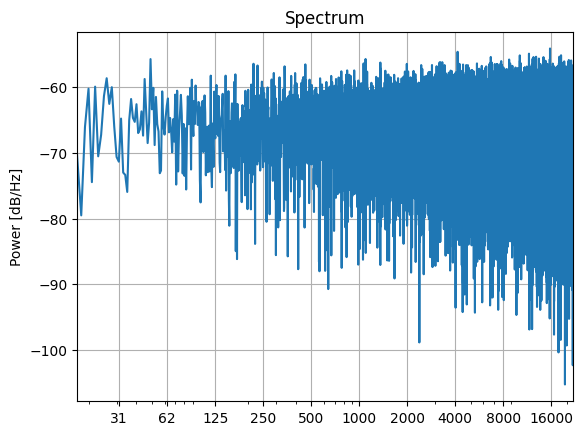

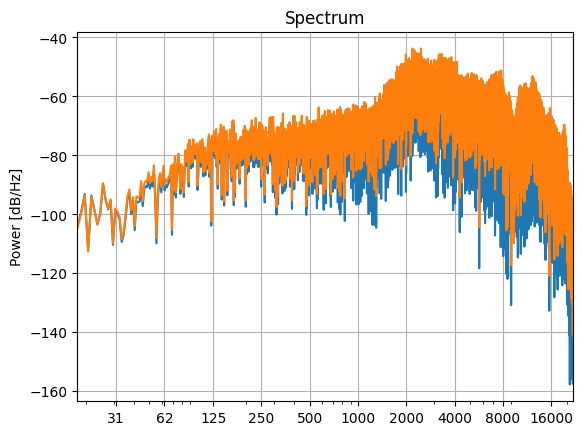

In [ ]:
hrtf1 = hrtf.interpolate(azimuth=-45,elevation=10)
stim = slab.Sound.whitenoise()
stim.spectrum()
stim = hrtf1.apply(0, stim)
stim.spectrum()
stim.play()

### Going further
*   Explore the KEMAR HRTF by plotting filter spectra at different cones of confusions.
*   Generate virtual sound sources at different directions. By concatenating them (for instance using the `.sequence` method) you can make a sound moving around you in a circle.
*   Does the KEMAR HRTF "work" for you, i.e. do the directions sound realistic?
*   See the documentation for [HRTFs on slab.readthedocs](https://slab.readthedocs.io/en/latest/hrtf.html).
*   HRTFs are a special case of filter. Slab has a whole [`Filter`](https://slab.readthedocs.io/en/latest/filter.html) class that helps you with designing, plotting, and applying filters and filterbanks.

## Filters

The `Filter` class can be used to generate, manipulate and save filter banks and transfer functions. Filters are represented internally as `Signal` and come in two flavours: finite impulse responses (FIR) and frequency bin amplitudes (FFT).

The easiest way to filter a sound is to use its `.filter` method, a convenience function that wraps around `Filter.cutoff_filter()` and `Filter.apply()`:

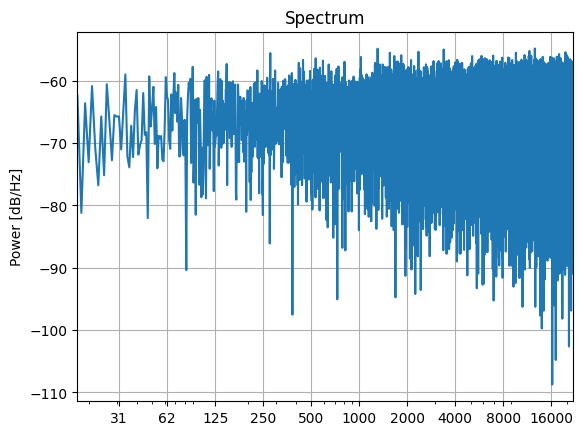

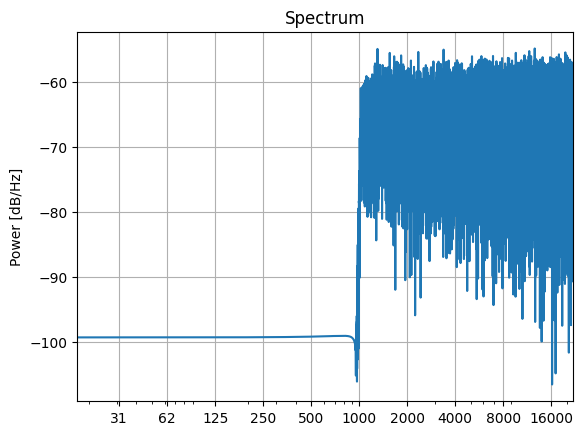

In [ ]:
noise = slab.Sound.whitenoise()
noise.spectrum()
noise_filtered = noise.filter(frequency=1000, kind='hp')
noise_filtered.spectrum()

This is equivalent to using the `Filter` class like shown below. Having the filter object lets you plot the transfer function, which is always a good idea to verify that the filter design worked.


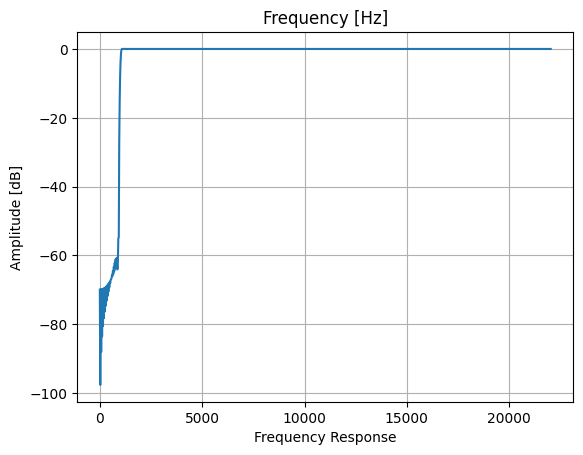

In [ ]:
filt = slab.Filter.band(frequency=1000, kind='hp')
noise_filtered = filt.apply(noise)
filt.tf()  # plot the transfer function of the filter

### Filterbanks

A Filter objects can hold multiple channels, just like a Sound object. In the following, we will refer to filters with multiple channels as filter banks. When you apply a filter bank to a single sound, each filter will be applied to a separate copy of the sound and the `apply()` method returns a multi-channel sound with one channel for each filter in the bank.

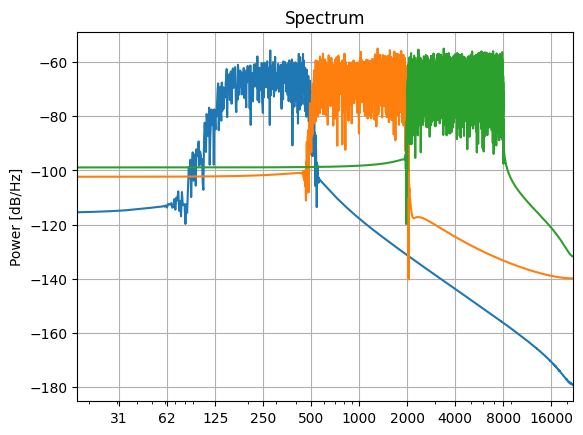

3

In [ ]:
filters = []
low_cutoff_freqs = [125, 500, 2000]
high_cutoff_freqs = [500, 2000, 8000]
for low, high in zip(low_cutoff_freqs, high_cutoff_freqs):
    filters.append(slab.Filter.band(frequency=(low, high), kind='bp'))
fbank = slab.Filter(filters)  # put the list into a single filter object
noise_bands = fbank.apply(noise)  # apply each filter to a copy of sound
noise_bands.spectrum()
noise_bands.n_channels

Filterbanks with many narrowband filters are commonly used in sound analysis and synthesis, and slab provides a way to generate such a bank:

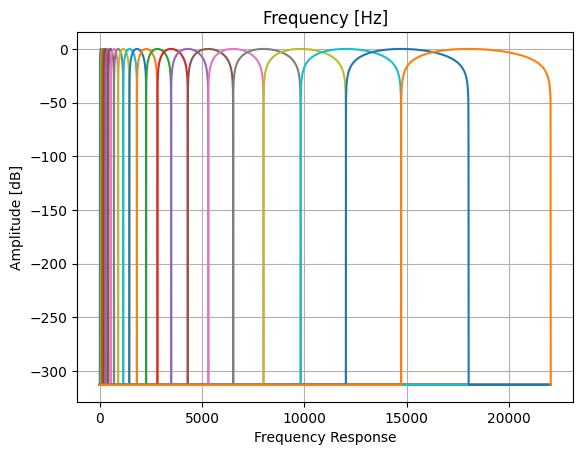

In [6]:
fbank = slab.Filter.cos_filterbank()
fbank.tf()

This filterbank will split a sound into many frequency bands, which we can then manipulate independently and recombine to synthesise a new sound. An example of such a process is vocoding. Vocoding replaces each subband of a speech signal with noise of the same envelope. This removes pitch information from speech and simulates a cochlear implant. Here is an example using very cheply synthesized vowels a speech:

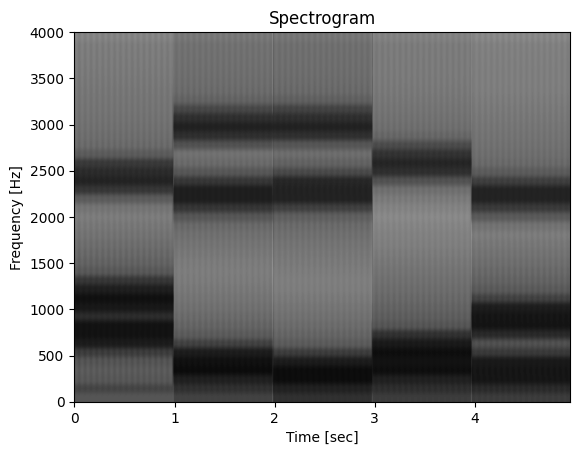

In [8]:
slab.set_default_samplerate(8000)
vowel_names = ["a", "e", "i", "o", "u"]
vowels = []
for vowel in vowel_names:
    vowels.append(slab.Sound.vowel(vowel))
speech = slab.Sound.crossfade(*vowels)
speech.spectrogram()
speech.play()

Let's vocode this signal:

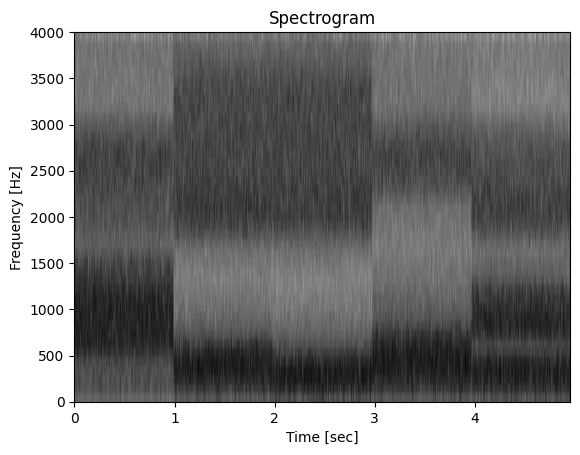

In [9]:
vocoded = speech.vocode()
vocoded.spectrogram()
vocoded.play()

The formant frequencies are the same, but the glottal pulses and pitch have been replaced by narrowband noise at the same frequencies and with the same envelopes.

You can inspect the `.vocode` method to see how this is done. Filterbanks allow a concise and elegant implementation of the algorithm in just 8 lines of code:

In [12]:
fbank = slab.Filter.cos_filterbank(length=speech.n_samples) # make the filter bank
subbands = fbank.apply(speech) # get a sound channel for each filter channel
envs = subbands.envelope() # now get the envelope of each frequency band
noise = slab.Sound.whitenoise(duration=speech.n_samples) # prepare white noise...
subbands_noise = fbank.apply(noise) # ...in the same frequency bands
subbands_noise *= envs  # fill the speech envelopes with noise
subbands_noise.level = subbands.level # keep subband level of original
# the last step is to collapse the subbands into one signal:
vocoded2 = slab.Filter.collapse_subbands(subbands_noise, filter_bank=fbank)
vocoded2.play()

### Going further
*   Explore the different filter options by applying them to sounds.
*   The `Filter` also has methods to estimate inverse filters to equalise loudspeakers and headphones. See the documentation for [Filter on slab.readthedocs](https://slab.readthedocs.io/en/latest/filters.html).
*   Try building stimuli from published experiments from the description in the Methods section using slab. For psychoacoustic experiments, you can try to replicate the entire experiment as an exercise.